notes on 2020.1.31
- 23.5 k cases: rain coverage >= 10%, median threat score: 0.53
- revise Du's code so it only calculates 60 minutes' prediction
- test Du's code comprehensive to compare its performance

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

from rainymotion import models, metrics, utils
from collections import OrderedDict
import h5py
import wradlib.ipol as ipol
from datetime import datetime,timedelta
import pandas as pd
import joblib
data_folder = "/Users/jiang/data/jma_radar"
daily_folder = "/Users/jiang/data/jma_radar/2019_daily_unit8"
csv_path = os.path.join(data_folder,"threat_coverage.csv")
data0 = pd.read_csv(csv_path)

/Users/jiang/github_all/rainymotion/docs/notebooks


In [2]:
select = np.random.choice(23508, 100).astype(np.int16)
print(data0.loc[select, "threat"].median())
select = np.random.choice(23508, 100).astype(np.int16)
print(data0.loc[select, "threat"].median())
select = np.random.choice(23508, 100).astype(np.int16)
print(data0.loc[select, "threat"].median())

0.5055528059970404
0.5570249286005058
0.5204574776268753


In [3]:
%%time

time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h

model = models.Dense60()
daily_database = {}

inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)
select = np.random.choice(23508, 100).astype(np.int16)
select.sort()
select_threat = []
per_threat = []
for i in select:  
    dt =     datetime.strptime(data0.loc[i,"datetime"], '%Y-%m-%d %H:%M:%S')
    dt_now = dt + timedelta(seconds = time_step)
    dt_12  = dt + timedelta(seconds = time_step * 13)
    yday_str = dt.strftime('%Y_%m_%d')    
    yday_now = dt_now.strftime('%Y_%m_%d')
    yday_12 =  dt_12.strftime('%Y_%m_%d')

    if yday_str not in daily_database:
        daily_database[yday_str] = joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_str}.joblib"))
    if yday_12 not in daily_database:
        daily_database[yday_12] =  joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_12}.joblib")) 
    
    inputs[0,:,:] = daily_database[yday_str][int(dt.hour*12     + (dt.minute)/5)]/10.0   # back to original scale
    inputs[1,:,:] = daily_database[yday_now][int(dt_now.hour*12 + (dt_now.minute)/5)]/10.0
    gt_in_60_min =   daily_database[yday_12][int(dt_12.hour*12  + (dt_12.minute)/5)]/10.0
    model.input_data = inputs
    nowcast = model.run()  
    select_threat.append(metrics.CSI(gt_in_60_min, nowcast, threshold = threshold))
    per_threat.append(metrics.CSI(gt_in_60_min, inputs[1,:,:], threshold = threshold)) 
# Wall time: 1 min

CPU times: user 5min, sys: 26.6 s, total: 5min 26s
Wall time: 1min 24s


In [4]:
%%time

import json
from src import of as optical_flow

with open("./config/prec/running.json", 'r') as f:
    param = json.load(f)

param['io']['raw_size'] = tuple(param['io']['raw_size'])
param['io']['downsample_size'] = tuple(param['io']['downsample_size'])
if param['img_fig']['figsize'] is not None:
    param['img_fiwg']['figsize'] = tuple(param['img_fig']['figsize'])
if param['vector_fig']['figsize'] is not None:
    param['vector_fig']['figsize'] = tuple(param['vector_fig']['figsize'])

of = getattr(optical_flow, 'PyramidHornSchunck')(**param['hs']['basic'])

time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h

daily_database = {}

inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)
du_threat = []
for i in select:  
    dt =     datetime.strptime(data0.loc[i,"datetime"], '%Y-%m-%d %H:%M:%S')
    dt_now = dt + timedelta(seconds = time_step)
    dt_12  = dt + timedelta(seconds = time_step * 13)
    yday_str = dt.strftime('%Y_%m_%d')    
    yday_now = dt_now.strftime('%Y_%m_%d')
    yday_12 =  dt_12.strftime('%Y_%m_%d')

    if yday_str not in daily_database:
        daily_database[yday_str] = joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_str}.joblib"))
    if yday_12 not in daily_database:
        daily_database[yday_12] =  joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_12}.joblib")) 
    
    inputs[0,:,:] = daily_database[yday_str][int(dt.hour*12     + (dt.minute)/5)]/10.0   # back to original scale
    inputs[1,:,:] = daily_database[yday_now][int(dt_now.hour*12 + (dt_now.minute)/5)]/10.0
    up_lmt = np.max(inputs)
    im0 = inputs[0,:,:].astype(np.float32) / up_lmt * 255
    im1 = inputs[1,:,:].astype(np.float32) / up_lmt * 255
    gt_in_60_min =   daily_database[yday_12][int(dt_12.hour*12  + (dt_12.minute)/5)]/10.0
    param['hs']['smooth']['threshold'] = np.quantile(im0[im0 > 1e-3], .2)
    of(im1, im0)

    for m in param['hs']['smooth']['methods']:
        of.smooth_vel(mode=m, **param['hs']['smooth'])
    u, v = of.u.copy(), of.v.copy()
    u *= param['hs']['basic']['dx']
    v *= param['hs']['basic']['dy']
    
    # make a source meshgrid
    coord_source_i, coord_source_j = np.meshgrid(range(u.shape[1]),range(u.shape[0]))
    coord_source = [coord_source_i, coord_source_j]
    # calculate new coordinates of radar pixels
    coord_target_i = coord_source_i + u * 12
    coord_target_j = coord_source_j + v * 12
    coord_targets =[coord_target_i, coord_target_j]
    du = models._interpolator(inputs[1,:,:], coord_source, coord_targets, method= "idw")
 
    du_threat.append(metrics.CSI(gt_in_60_min, du, threshold = threshold))
# Wall time: 21 min

/Users/jiang/anaconda3/envs/rainymotion/lib/python3.8/site-packages/wradlib/ipol.py:368: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / self.dists ** self.p


CPU times: user 39min 19s, sys: 1min 58s, total: 41min 17s
Wall time: 21min 54s


## convert to panda dataframe and do data analysis

In [5]:
data = data0.loc[select,:]
data['threat_new']  = select_threat
data['threat_du']   = du_threat
data['threat_per']  = per_threat
np.median(data.threat), np.median(data.threat_new), np.median(data.threat_du), np.median(data.threat_per)

(0.5115791185229677,
 0.5144389316338687,
 0.4415918390108316,
 0.4172025702501573)

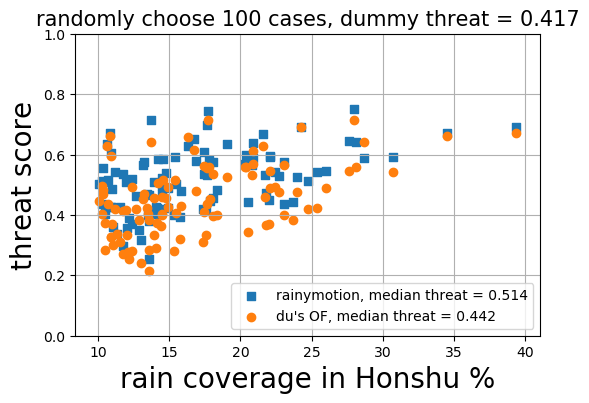

In [7]:
plt.figure(dpi=100)
plt.scatter(data.coverage, data.threat_new, marker = 's', label = f"rainymotion, median threat = {np.median(data.threat_new):.3f}")
plt.scatter(data.coverage, data.threat_du, marker = 'o',label = f"du's OF, median threat = {np.median(data.threat_du):.3f}")
plt.legend(loc = 'lower right')
plt.title(f"randomly choose 100 cases, dummy threat = {np.median(data.threat_per):.3f}",fontsize= 15)
plt.xlabel("rain coverage in Honshu %",fontsize= 20)
plt.ylabel("threat score",fontsize= 20)
plt.ylim([0,1])
plt.grid()
plt.show()

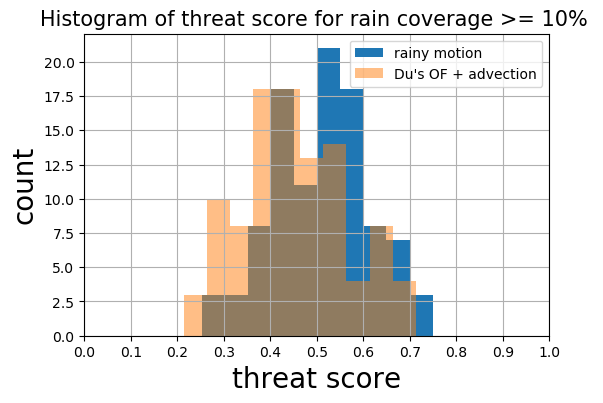

In [8]:
plt.figure(dpi = 100)
plt.hist(data.threat_new,10, label = "rainy motion")
plt.hist(data.threat_du,10, label = "Du's OF + advection", alpha = 0.5)

plt.legend()
plt.title("Histogram of threat score for rain coverage >= 10% ",fontsize= 15)
plt.xlabel("threat score",fontsize= 20)
plt.ylabel("count",fontsize= 20)
plt.xticks(np.linspace(0,1,11))
plt.xlim([0,1])
plt.grid()
plt.show()